In [1]:
!pip install -q kaggle
!pip install transformers
!pip install unidecode
!pip install torch
!pip install tqdm
!pip install transformers
!pip install livelossplot==0.5.4

In [2]:
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [67]:
from google.colab import files
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertConfig
from livelossplot import PlotLosses

In [4]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c home-depot-product-search-relevance

mkdir: cannot create directory ‘/root/.kaggle’: File exists
attributes.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
relevance_instructions.docx: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
product_descriptions.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

 attributes.csv.zip   product_descriptions.csv.zip   sample_submission.csv.zip
'kaggle (1).json'     relevance_instructions.docx    test.csv.zip
 kaggle.json	      sample_data		     train.csv.zip


In [8]:
att_df= pd.read_csv('attributes.csv.zip')
desc_df= pd.read_csv('product_descriptions.csv.zip')
df = pd.read_csv('train.csv.zip', encoding='latin-1')
test_df = pd.read_csv('test.csv.zip',encoding='latin-1')


In [9]:
desc_df = desc_df.fillna(0)
df = df.fillna(0)

test_df = test_df.fillna(0)
att_df = att_df.fillna(0)

desc_df['product_uid'] = desc_df['product_uid'].astype(np.int64)
df['product_uid'] = df['product_uid'].astype(np.int64)
test_df['product_uid'] = test_df['product_uid'].astype(np.int64)
att_df['product_uid'] = att_df['product_uid'].astype(np.int64)

In [10]:
df.sample(2)

,id,product_uid,product_title,search_term,relevance
26262,80579,123538,32.5 in.x 32 in. Metal Gemstone Forest Wall Sc...,metal wall art,2.67
30206,92434,128292,Mont Blanc Northbrook Drop-in Composite Granit...,single bowl kitchen sinks 25 x 22 x 9,2.67


In [11]:
np.min(df['relevance'].tolist()), np.max(df['relevance'].tolist())

(1.0, 3.0)

In [37]:
unique_values = pd.unique(df['relevance']).tolist()
num_of_unique_values = len(unique_values)
sorted(unique_values), num_of_unique_values

([1.0, 1.25, 1.33, 1.5, 1.67, 1.75, 2.0, 2.25, 2.33, 2.5, 2.67, 2.75, 3.0], 13)

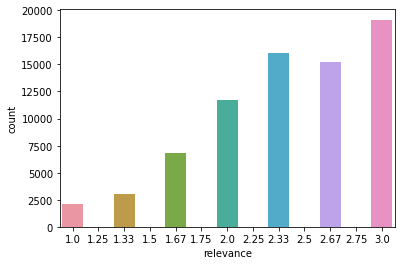

In [40]:
# np.bincount(df['relevance'].tolist(), minlength = num_of_unique_values)
ax = sns.countplot(x="relevance", data=df)


In [43]:
mapping = {1.25: 1.33, 1.5: 1.67, 1.75: 2.0, 2.25: 2.33, 2.5: 2.67, 2.75: 3.0}
df['relevance'] = df['relevance'].apply(lambda relevance: mapping[relevance] if relevance in mapping else relevance)

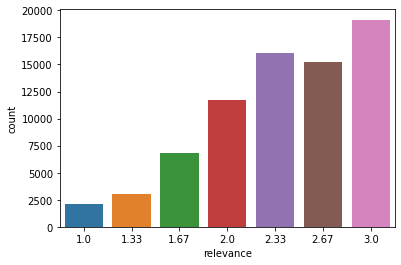

In [44]:
ax = sns.countplot(x="relevance", data=df)

In [45]:
df.describe()

,id,product_uid,relevance,relevance_class
count,74067.000000,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381773,8.289049
std,64016.573650,30770.774864,0.533978,3.202216
min,2.000000,100001.000000,1.000000,0.000000
25%,57163.500000,115128.500000,2.000000,6.000000
50%,113228.000000,137334.000000,2.330000,8.000000
75%,168275.500000,166883.500000,3.000000,12.000000
max,221473.000000,206650.000000,3.000000,12.000000


In [46]:



tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_SEARCH_TERM_LENGTH = 15
MAX_TITLE_LENGTH = 50

In [47]:
def tokenize(text, max_length):
  
  return tokenizer.encode_plus(
            text,
            max_length = max_length, 
            padding = 'max_length',
            truncation = True, 
            return_attention_mask = True, 
            add_special_tokens = True, 
            )
  


In [48]:
df['product_title_tokens'] = df['product_title'].progress_apply(lambda text: tokenize(text, MAX_TITLE_LENGTH))

100%|██████████| 74067/74067 [00:32<00:00, 2249.00it/s]


In [49]:
df['search_term_tokens'] = df['search_term'].progress_apply(lambda text: tokenize(text, MAX_SEARCH_TERM_LENGTH))

100%|██████████| 74067/74067 [00:17<00:00, 4341.65it/s]


In [50]:
test_df['product_title_tokens'] = test_df['product_title'].progress_apply(lambda text: tokenize(text, MAX_TITLE_LENGTH))

100%|██████████| 166693/166693 [01:14<00:00, 2233.16it/s]


In [51]:
test_df['search_term_tokens'] = test_df['search_term'].progress_apply(lambda text: tokenize(text, MAX_SEARCH_TERM_LENGTH))

100%|██████████| 166693/166693 [00:36<00:00, 4587.03it/s]


In [52]:
relevance_values = sorted(pd.unique(df['relevance']).tolist())
relevance_map = {relevance: index for (index, relevance) in enumerate(relevance_values)}
num_of_classes = len(relevance_map)
relevance_map, num_of_classes

({1.0: 0, 1.33: 1, 1.67: 2, 2.0: 3, 2.33: 4, 2.67: 5, 3.0: 6}, 7)

In [53]:
cls_to_score = {cls: score for (score, cls) in relevance_map.items()}
cls_to_score

{0: 1.0, 1: 1.33, 2: 1.67, 3: 2.0, 4: 2.33, 5: 2.67, 6: 3.0}

In [54]:

df['relevance_class'] = df['relevance'].apply(lambda relevance: relevance_map[relevance])
test_df['relevance_class'] = -1
pd.unique(df['relevance_class'])


array([6, 5, 4, 3, 0, 2, 1])

In [56]:
num_of_classes = len(pd.unique(df['relevance_class']))
num_of_classes

7

In [57]:
np.bincount(df['relevance_class'].tolist())

array([ 2105,  3010,  6785, 11739, 16071, 15221, 19136])

In [58]:
import random
import time
random.seed(int(time.time()))
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn, utils
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

class DatasetLoader(Dataset):

    def __init__(self, df):
        self._df = df


    def __len__(self):
        return len(self._df)
    def __getitem__(self, idx):
        row = self._df.iloc[idx]

        search_term = np.array(row['search_term_tokens']['input_ids'])
        search_term_attention_mask = np.array(row['search_term_tokens']['attention_mask'])
        product_title = np.array(row['product_title_tokens']['input_ids'])
        product_title_attention_mask = np.array(row['product_title_tokens']['attention_mask'])

   

        return row['id'], search_term, search_term_attention_mask, product_title, product_title_attention_mask, row['relevance_class']
    


In [62]:
training_df, validation_df = train_test_split(df, test_size=0.1, random_state=42)
len(training_df), len(validation_df), len(df)

(66660, 7407, 74067)

In [86]:
BATCH_SIZE = 32

train_dataset = DatasetLoader(training_df[['id', 'product_title_tokens', 'search_term_tokens', 'relevance_class']].sample(200))

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)


validation_dataset = DatasetLoader(validation_df[['id', 'product_title_tokens', 'search_term_tokens', 'relevance', 'relevance_class']])

valiodation_data_loader = torch.utils.data.DataLoader(validation_dataset,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)


test_dataset = DatasetLoader(test_df[['id', 'product_title_tokens', 'search_term_tokens', 'relevance_class']])

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=BATCH_SIZE, shuffle=False, 
                                                 num_workers=4,drop_last=False)

len(train_data_loader), len(valiodation_data_loader), len(test_data_loader)

(7, 232, 5210)

In [95]:
class RelevanceModel(nn.Module):

  BERT_MODEL_NAME = 'bert-base-cased'

  def __init__(self, num_of_classes):
    super(RelevanceModel, self).__init__()
    config = BertConfig.from_pretrained("bert-base-uncased",
                                    output_hidden_states=True)

    
    self.bert = BertModel.from_pretrained(RelevanceModel.BERT_MODEL_NAME, return_dict=True)

    self.bert.resize_token_embeddings(len(tokenizer))


    # for param in self.bert.parameters():
    #   param.requires_grad = False

    self.fc1 = nn.Linear(768 * 2, 512)
    self.fc2 = nn.Linear(512, num_of_classes)


  def  forward(self, queries, queries_masks, titles, titles_masks):
 
    encoded_queries = self.bert(queries, attention_mask=queries_masks)
    encoded_titles = self.bert(titles, attention_mask=titles_masks)


    out = torch.cat((encoded_queries.pooler_output, encoded_titles.pooler_output), 1)

    out = self.fc1(out)
    out = torch.relu(out)
    out = self.fc2(out)

    return out 


  def reset_parameters(self):
    nn.init.uniform_(self.fc1.weight)
    nn.init.uniform_(self.fc2.weight)


In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [71]:
# counts = df.groupby("relevance_class").size().reset_index()
# total = 0.0
# for _, row in counts[['relevance_class', 0]].iterrows():
#   total += row[0]
# total 
# weights = []
# for _, row in counts[['relevance_class', 0]].iterrows():

#   cls = row['relevance_class']
#   sampeples_weight = (row[0] / total)
#   required_weight = 1.0/len(counts)
#   x = required_weight/sampeples_weight
#   weight_for_class_a = (1 / row[0]) * total/len(counts)
#   weights.append((cls, x))


# weights = sorted(weights, key = lambda x: x[0])
# weights = [w[1] for w in weights]
# weights

[5.026603325415676,
 3.5152823920265774,
 1.559469417833456,
 0.9013544594939944,
 0.6583908904237447,
 0.6951580053872939,
 0.552936872909699]

In [75]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', np.unique(df.relevance_class),  df.relevance_class)

weights

array([5.02660333, 3.51528239, 1.55946942, 0.90135446, 0.65839089,
       0.69515801, 0.55293687])

In [96]:
# from transformers import AutoModel, BertTokenizerFast

model = RelevanceModel(num_of_classes)
model.reset_parameters()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
class_weights_tensor = torch.tensor(weights,dtype=torch.float)
criterion = torch.nn.CrossEntropyLoss(weight = class_weights_tensor, reduction='mean').to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [97]:

def train_epoc():

  model.train()

  running_loss = 0.0
  counter = 0.0
  correct_classified = 0.0 
  for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in train_data_loader: #train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    target_relevance_score = Variable(target_relevance_score).long().to(device)

    search_term_mask = Variable(search_term_mask).to(device)
    product_title_mask = Variable(product_title_mask).to(device)
    

    optimizer.zero_grad()

    scores = model(search_term, search_term_mask,  product_title, product_title_mask)
    
    loss = criterion(scores, target_relevance_score)

    

    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    counter += search_term.shape[0]
    correct_classified += np.sum(torch.argmax(scores, dim=1).cpu().detach().numpy()== target_relevance_score.cpu().numpy())

  return running_loss/counter, correct_classified/counter



def validation():
  model.eval()

  running_loss  = 0.0
  counter = 0.0

  correct_classified = 0.0 

  with torch.no_grad():
    for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score in valiodation_data_loader:
      search_term = Variable(search_term).to(device)
      product_title = Variable(product_title).to(device)

      search_term_mask = Variable(search_term_mask).to(device)
      product_title_mask = Variable(product_title_mask).to(device)

      target_relevance_score = Variable(target_relevance_score).float().to(device)

      scores = model(search_term, search_term_mask,  product_title, product_title_mask)

    
      
      loss = criterion(scores, target_relevance_score.long())
      running_loss += loss.item()
      counter += search_term.shape[0]
      correct_classified += np.sum(torch.argmax(scores, dim=1).cpu().detach().numpy()== target_relevance_score.cpu().numpy())
  

  return running_loss/counter, correct_classified/counter  




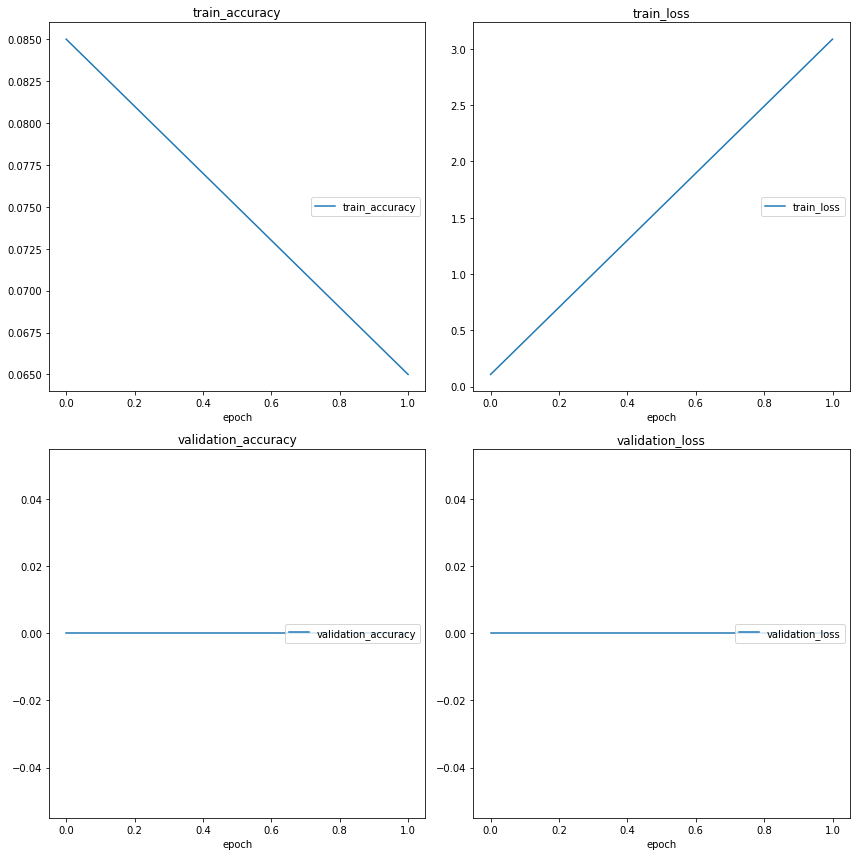

train_accuracy
	train_accuracy   	 (min:    0.065, max:    0.085, cur:    0.065)
train_loss
	train_loss       	 (min:    0.109, max:    3.086, cur:    3.086)
validation_accuracy
	validation_accuracy 	 (min:    0.000, max:    0.000, cur:    0.000)
validation_loss
	validation_loss  	 (min:    0.000, max:    0.000, cur:    0.000)


In [ ]:
liveloss = PlotLosses()

for epoc in range(1000):

  train_loss, train_accuracy = train_epoc()
  validation_loss, val_accuracy = 0,0 #validation()

  liveloss.update({
          'train_loss': train_loss,
          'validation_loss': validation_loss,

          'train_accuracy': train_accuracy,
          'validation_accuracy': val_accuracy
      })
    
  liveloss.draw()

In [ ]:
# for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in o_data_loader:
#   break

# search_term = Variable(search_term).to(device)
# product_title = Variable(product_title).to(device)

# search_term_mask = Variable(search_term_mask).to(device)
# product_title_mask = Variable(product_title_mask).to(device)

search_term.shape

torch.Size([6, 15])

In [ ]:
np.sum(torch.argmax(scores, dim=1).detach().cpu().numpy() == target_relevance_score.numpy())

13

In [ ]:
r1, scores.shape

NameError: ignored

In [83]:


model.eval()
test_scores = []
test_ids =[]
tt = []


with torch.no_grad():
  for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score in train_data_loader:
    search_term = Variable(search_term).to(device)
    search_term_mask = Variable(search_term_mask).to(device)


    product_title = Variable(product_title).to(device)
    product_title_mask = Variable(product_title_mask).to(device)
    
    scores = model(search_term, search_term_mask,  product_title, product_title_mask)

    res = torch.argmax(scores, dim=1)


    break
    # out = torch.cat((encoded_queries.pooler_output, encoded_titles.pooler_output), 1
  



In [84]:
res
                

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [ ]:
xx.last_hidden_state.shape, xx.pooler_output.shape, len(xx.hidden_states[0])

(torch.Size([64, 5, 768]), torch.Size([64, 768]), 64)

In [67]:

for ids, search_term, search_term_mask, product_title, product_title_mask, target_relevance_score  in train_data_loader: #train_data_loader:
  break

search_term.shape, search_term_mask.shape

(torch.Size([32, 15]), torch.Size([32, 15]))

In [ ]:
# 166693, len(test_data), len(test_df)
all_ids = {x for (x, _) in test_data}

for _, row in test_df.iterrows():
  if row['id'] not in all_ids:
    test_data.append((row['id'], 1))
    
len(test_data)

166693

In [ ]:
yy = df.sample(10)[['product_title', 'search_term', 'relevance', 'relevance_class', 'product_title_tokens', 'search_term_tokens']]
yy

,product_title,search_term,relevance,relevance_class,product_title_tokens,search_term_tokens
6952,Delta Porter 4 in. Centerset 2-Handle High-Arc Bathroom Faucet in Oil Rubbed Bronze,Bronze bath rug,1.00,5,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
6394,Husky 8-Pocket Nail Pouch,nail bags,2.67,3,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
34189,RIDGID JobMax 12-Volt Multi-Tool Starter Kit,ridgid 12 volt,3.00,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
23924,MOEN Brantford Tank Lever in Brushed Nickel,moen brantford nickel,3.00,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
14101,WeatherStar 36 in. x 55 in. 2-Track Storm Aluminum Window,Aluminum track for windows,2.00,4,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
65139,DEWALT Harsh Condition Insulated Size Large Work Glove,Insulted work gloves,3.00,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
33636,A-C Draftshields 12 in. x 12 in. Vent Cover,8x22 a/c vent,1.33,7,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
70402,Commercial Electric 2 in. 45å¡ Sch. 40 Belled End Elbow,2 pipe 45,3.00,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
57216,Commercial Electric 11 in. Cable Tie - Natural (100-Pack),commercial smart tie,2.33,2,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
20838,Nature Power Bayport 72 in. Black Outdoor Solar Lamp Post with Super Bright Natural White LED,post lamp tier,2.67,3,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
i = 0
yy.iloc[i]['product_title'], tokenizer.convert_ids_to_tokens(yy.iloc[i]['product_title_tokens']['input_ids'])

('Delta Porter 4 in. Centerset 2-Handle High-Arc Bathroom Faucet in Oil Rubbed Bronze',
 ['[CLS]',
  'delta',
  'porter',
  '4',
  'in',
  '.',
  'centers',
  '##et',
  '2',
  '-',
  'handle',
  'high',
  '-',
  'arc',
  'bathroom',
  'fa',
  '##uce',
  '##t',
  'in',
  'oil',
  'rubbed',
  'bronze',
  '[SEP]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[P